In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import os
from io import StringIO

# --- AYARLAR ---
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)


Importing Libraries and Setting Visualization Preferences

In this section, we import all the necessary Python libraries required for data processing, statistical analysis, and visualization:

pandas – used for reading, cleaning, and manipulating datasets.

numpy – provides numerical operations and array handling.

matplotlib.pyplot – the core plotting library for creating visualizations.

seaborn – a statistical visualization library built on top of matplotlib that provides cleaner and more aesthetic plots.

scipy.stats.pearsonr – used for computing Pearson correlation coefficients and p-values.

os – allows file and directory handling (used for automated file detection).

StringIO – helps convert multi-line strings into file-like objects so they can be read as datasets.

After importing these libraries, we configure the visual style:

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)


sns.set(style="whitegrid")
Sets the Seaborn plotting style to whitegrid, which adds subtle gridlines and improves readability of scatterplots and regression plots.

plt.rcParams['figure.figsize'] = (16, 12)
Makes all generated figures larger by default (16×12 inches).
This ensures the plots are clear, spacious, and easy to analyze, especially when displaying multiple subplots on the same figure.

In [ ]:
# --- 1. FONKSİYONLAR ---
def sehir_ismi_duzelt(isim):
    if isinstance(isim, str):
        if "TR" in isim:
            if "," in isim: isim = isim.split(',')[1]
            elif " " in isim: isim = isim.split(' ', 1)[1]
        isim = isim.replace('i', 'İ').upper()
        isim = isim.replace('ı', 'I')
        return isim.strip()
    return ""

def dosya_oku_koordinatli(anahtar_kelime, satir_baslangic):
    dosyalar = os.listdir('.')
    dosya_yolu = next((f for f in dosyalar if anahtar_kelime.lower() in f.lower()), None)

    if not dosya_yolu:
        print(f"⚠️ UYARI: '{anahtar_kelime}' kelimesini içeren dosya bulunamadı!")
        return None

    print(f"📖 Okunuyor: {dosya_yolu} (Başlangıç: {satir_baslangic}. satır)")
    skip = satir_baslangic - 1

    try:
        # Önce CSV olarak dene
        try:
            return pd.read_csv(dosya_yolu, skiprows=skip, header=None, sep=None, engine='python')
        except:
            # Olmazsa Excel olarak dene
            return pd.read_excel(dosya_yolu, skiprows=skip, header=None)
    except Exception as e:
        print(f"❌ '{dosya_yolu}' dosyası okunurken hata oluştu: {e}")
        return None

# --- IQR FİLTRELEME FONKSİYONU ---
def iqr_filtrele(df, kolon):
    """Aykırı değerleri temizler ve temiz veriyi döndürür."""
    Q1 = df[kolon].quantile(0.25)
    Q3 = df[kolon].quantile(0.75)
    IQR = Q3 - Q1
    alt = Q1 - 1.5 * IQR
    ust = Q3 + 1.5 * IQR
    df_clean = df[(df[kolon] >= alt) & (df[kolon] <= ust)]
    atilan_sayisi = len(df) - len(df_clean)
    atilanlar = df[~df.index.isin(df_clean.index)]['Il'].tolist()
    return df_clean, atilan_sayisi, atilanlar

print("🚀 KAPSAMLI VERİMLİLİK VE KORELASYON ANALİZİ BAŞLIYOR...")


1. Helper Functions

This section defines three key helper functions that are used throughout the data processing and analysis workflow.

a. sehir_ismi_duzelt() — City Name Standardization

This function standardizes city names obtained from different datasets.
It performs the following steps:

Removes leading region codes such as "TR-XX" if present.

Handles two possible formats:

"TR, İstanbul" → extracts "İstanbul"

"TR İstanbul" → extracts "İstanbul"

Converts Turkish characters to consistent uppercase formatting:

Replaces "i" with "İ" before converting the string to uppercase to preserve correct Turkish spelling.

Replaces "ı" with "I".

Strips whitespace and returns a clean, uniform city name.

This ensures that data coming from different sources can be merged reliably on the "Il" (City) column.

b. dosya_oku_koordinatli() — File Loader with Row-Based Offset

This function automatically searches the working directory for a file whose name contains a given keyword (e.g., "sinema", "tiyatro", "hasila").

Once the file is found, the function:

Prints which file is being read and from which row.

Converts the Excel-style row number (starting from 1) into Python indexing (skiprows = satir_baslangic - 1).

Attempts to read the file:

First tries reading as CSV.

If that fails, attempts reading as an Excel file.

This flexible approach allows the script to work with different formats without manually specifying file paths or extensions.

If the file cannot be read, the function prints an error message and returns None.

c. iqr_filtrele() — Outlier Removal Using the IQR Method

This function removes outliers from a specified numeric column using the Interquartile Range (IQR) method.

Steps:

Calculates:

Q1: 25th percentile

Q3: 75th percentile

IQR = Q3 - Q1

Computes outlier thresholds:

Lower bound = Q1 - 1.5 * IQR

Upper bound = Q3 + 1.5 * IQR

Filters out values outside this range.

Returns:

The cleaned dataset (df_clean)

The number of removed rows (atilan_sayisi)

A list of removed city names (atilanlar)

This function is essential for producing additional “cleaned” analyses that exclude extreme values affecting correlation results.

Startup Message
print("🚀 KAPSAMLI VERİMLİLİK VE KORELASYON ANALİZİ BAŞLIYOR...")


This line simply prints a visual indicator that the workflow has begun.

In [ ]:
# ---------------------------------------------------------
    # ADIM 1: VERİ OKUMA (GÜVENLİ YÖNTEM)
    # ---------------------------------------------------------

    # 1. İşsizlik
    temp_issizlik = dosya_oku_koordinatli("issizlik", 8)
    if temp_issizlik is None: raise ValueError("İşsizlik dosyası okunamadı! Dosyaları yüklediğinden emin ol.")
    df_issizlik = temp_issizlik.iloc[:, [1, 7]]
    df_issizlik.columns = ['Il', 'Issizlik_Orani']
    df_issizlik['Il'] = df_issizlik['Il'].apply(sehir_ismi_duzelt)

    # 2. Sinema
    temp_sinema = dosya_oku_koordinatli("sinema", 6)
    if temp_sinema is None: raise ValueError("Sinema dosyası okunamadı!")
    df_sinema = temp_sinema.iloc[:, [0, 2, 8]]
    df_sinema.columns = ['Il', 'Sinema_Koltuk', 'Sinema_Seyirci']
    df_sinema['Il'] = df_sinema['Il'].apply(sehir_ismi_duzelt)

    # 3. Tiyatro
    temp_tiyatro = dosya_oku_koordinatli("tiyatro", 7)
    if temp_tiyatro is None: raise ValueError("Tiyatro dosyası okunamadı!")
    df_tiyatro = temp_tiyatro.iloc[:, [0, 2, 12]]
    df_tiyatro.columns = ['Il', 'Tiyatro_Koltuk', 'Tiyatro_Seyirci']
    df_tiyatro['Il'] = df_tiyatro['Il'].apply(sehir_ismi_duzelt)

    # 4. GSYH (Gelir)
    temp_gsyh = dosya_oku_koordinatli("hasila", 6)
    if temp_gsyh is None: raise ValueError("GSYH (Hasıla) dosyası okunamadı!")
    df_gsyh = temp_gsyh.iloc[:, [1, 42]]
    df_gsyh.columns = ['Il', 'GSYH_Dolar']
    df_gsyh['Il'] = df_gsyh['Il'].apply(sehir_ismi_duzelt)

    # ---------------------------------------------------------
    # ADIM 2: BİRLEŞTİRME VE HESAPLAMA
    # ---------------------------------------------------------
    print("🔄 Veriler Birleştiriliyor...")
    df_master = df_sinema.merge(df_tiyatro, on='Il', how='inner')
    df_master = df_master.merge(df_issizlik, on='Il', how='inner')
    df_master = df_master.merge(df_gsyh, on='Il', how='inner')

    # Temizlik
    cols = ['Issizlik_Orani', 'Sinema_Koltuk', 'Sinema_Seyirci', 'Tiyatro_Koltuk', 'Tiyatro_Seyirci', 'GSYH_Dolar']
    for col in cols: df_master[col] = pd.to_numeric(df_master[col], errors='coerce').fillna(0)

    df_master = df_master[~df_master['Il'].str.contains("TURKIYE|TOPLAM", na=False)]
    df_master = df_master[df_master['Sinema_Koltuk'] > 0] # 0'a bölme hatası önlemi

    # Verimlilik (Yoğunluk) Hesapları
    df_master['Tiyatro_Yogunluk'] = df_master['Tiyatro_Seyirci'] / df_master['Tiyatro_Koltuk']
    df_master['Sinema_Yogunluk'] = df_master['Sinema_Seyirci'] / df_master['Sinema_Koltuk']

    # Sonsuz değerleri temizle
    df_master = df_master.replace([np.inf, -np.inf], 0)

    print(f"✅ Analiz Hazır! {len(df_master)} il işleniyor.")

    # ---------------------------------------------------------
    # ADIM 3: VERİLERİ HAZIRLAMA (IQR vs STANDART)
    # ---------------------------------------------------------

    # IQR Temizlenmiş Veriler
    df_clean_tiyatro, atilan_t_sayi, atilan_t_isim = iqr_filtrele(df_master, 'Tiyatro_Yogunluk')
    df_clean_sinema, atilan_s_sayi, atilan_s_isim = iqr_filtrele(df_master, 'Sinema_Yogunluk')

    # İstatistikler
    r_t_orig, p_t_orig = pearsonr(df_master['Issizlik_Orani'], df_master['Tiyatro_Yogunluk'])
    r_s_orig, p_s_orig = pearsonr(df_master['Issizlik_Orani'], df_master['Sinema_Yogunluk'])

    r_t_iqr, p_t_iqr = pearsonr(df_clean_tiyatro['Issizlik_Orani'], df_clean_tiyatro['Tiyatro_Yogunluk'])
    r_s_iqr, p_s_iqr = pearsonr(df_clean_sinema['Issizlik_Orani'], df_clean_sinema['Sinema_Yogunluk'])


Step 1–3: Data loading, merging, cleaning, and correlation checks (brief explanation)

1. Safe file reading

We load sinema, tiyatro, issizlik, and gsyh files using a helper that searches for filenames and reads starting from a given row.

If a required file is missing, the script raises a clear error so you don’t continue with incomplete data.

Why: ensures reproducibility and fails early if inputs are missing or incorrectly named.

2. Merge datasets into a master table

We inner-merge cinema and theatre, then merge unemployment and GDP so each row is a single province with all variables.

Drop aggregate rows like "TURKIYE" and any rows with zero capacity (to avoid division-by-zero).

Why: create a single, consistent panel (one row per city) so comparisons and ratios are meaningful.

3. Type conversion & basic cleaning

Convert numeric columns with pd.to_numeric(..., errors='coerce').fillna(0) to handle stray strings and missing cells.

Replace inf / -inf with 0 after ratio computations.

Why: avoid runtime errors and ensure numeric operations (ratios, correlations) are valid.

4. Compute utilization metrics (density / occupancy)

Tiyatro_Yogunluk = Tiyatro_Seyirci / Tiyatro_Koltuk

Sinema_Yogunluk = Sinema_Seyirci / Sinema_Koltuk

Why: raw seat or audience counts are scale-dependent; occupancy (audience per seat) is a normalized, comparable measure of cultural use across cities.

5. Outlier filtering with IQR and robustness checks

Use the IQR rule to remove extreme cities separately for theatre and cinema utilization (iqr_filtrele).

Compute Pearson correlations between unemployment and utilization on both the full dataset and the IQR-cleaned subsets.

Why: outliers can strongly bias correlation estimates. Comparing original vs cleaned results shows whether observed relationships are robust or driven by a few extreme cases.

6. Statistical output

pearsonr returns r and p-value for each test so you can report both effect size and statistical significance.

Why: reporting both the coefficient (strength/direction) and p-value (significance) is standard practice for transparent inference.

In [ ]:
 # ---------------------------------------------------------
    # ADIM 4: GÖRSELLEŞTİRME (SCATTER PLOTS)
    # ---------------------------------------------------------

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('İŞSİZLİK VE KÜLTÜREL VERİMLİLİK ANALİZİ\n(Üst: Tüm İller | Alt: Outlier Temizlenmiş)', fontsize=16)

    # 1. Tiyatro (Tüm İller)
    sns.regplot(data=df_master, x='Issizlik_Orani', y='Tiyatro_Yogunluk', ax=axes[0,0], color='purple', line_kws={'color':'red'})
    axes[0,0].set_title(f"Tiyatro Yoğunluğu (Tüm İller)\nR: {r_t_orig:.2f} (P: {p_t_orig:.4f})")

    # 2. Sinema (Tüm İller)
    sns.regplot(data=df_master, x='Issizlik_Orani', y='Sinema_Yogunluk', ax=axes[0,1], color='teal', line_kws={'color':'red'})
    axes[0,1].set_title(f"Sinema Yoğunluğu (Tüm İller)\nR: {r_s_orig:.2f} (P: {p_s_orig:.4f})")

    # 3. Tiyatro (IQR Temizlenmiş)
    sns.regplot(data=df_clean_tiyatro, x='Issizlik_Orani', y='Tiyatro_Yogunluk', ax=axes[1,0], color='mediumorchid', line_kws={'color':'blue'})
    axes[1,0].set_title(f"Tiyatro Yoğunluğu (IQR Temiz: {atilan_t_sayi} il atıldı)\nR: {r_t_iqr:.2f} (P: {p_t_iqr:.4f})")

    # 4. Sinema (IQR Temizlenmiş)
    sns.regplot(data=df_clean_sinema, x='Issizlik_Orani', y='Sinema_Yogunluk', ax=axes[1,1], color='lightseagreen', line_kws={'color':'blue'})
    axes[1,1].set_title(f"Sinema Yoğunluğu (IQR Temiz: {atilan_s_sayi} il atıldı)\nR: {r_s_iqr:.2f} (P: {p_s_iqr:.4f})")

    # Şehir isimlerini yazdır
    for i in range(len(df_clean_tiyatro)):
        row = df_clean_tiyatro.iloc[i]
        if row['Tiyatro_Yogunluk'] > df_clean_tiyatro['Tiyatro_Yogunluk'].mean() * 1.5:
            axes[1,0].text(row['Issizlik_Orani'], row['Tiyatro_Yogunluk'], row['Il'], fontsize=8)

    plt.tight_layout()
    plt.show()

    # ---------------------------------------------------------
    # ADIM 5: SONUÇ RAPORU (TEXT)
    # ---------------------------------------------------------
    print("\n" + "="*80)
    print("📊 DETAYLI SONUÇ TABLOSU")
    print("="*80)

    print(f"1️⃣ TİYATRO ANALİZİ:")
    print(f"   - TÜM İLLER: R={r_t_orig:.3f} | P={p_t_orig:.5f} ({'ANLAMLI' if p_t_orig<0.05 else 'ANLAMSIZ'})")
    print(f"   - IQR TEMİZ: R={r_t_iqr:.3f}  | P={p_t_iqr:.5f}  ({'ANLAMLI' if p_t_iqr<0.05 else 'ANLAMSIZ'})")
    print(f"   * Atılan İller: {atilan_t_isim[:5]}... (Toplam {atilan_t_sayi})")

    print("-" * 80)

    print(f"2️⃣ SİNEMA ANALİZİ:")
    print(f"   - TÜM İLLER: R={r_s_orig:.3f} | P={p_s_orig:.5f} ({'ANLAMLI' if p_s_orig<0.05 else 'ANLAMSIZ'})")
    print(f"   - IQR TEMİZ: R={r_s_iqr:.3f}  | P={p_s_iqr:.5f}  ({'ANLAMLI' if p_s_iqr<0.05 else 'ANLAMSIZ'})")
    print(f"   * Atılan İller: {atilan_s_isim[:5]}... (Toplam {atilan_s_sayi})")
    print("="*80)

    # ---------------------------------------------------------
    # ADIM 6: EKSTRA - DETAYLI KORELASYON ANALİZİ (HEATMAP)
    # ---------------------------------------------------------

    print("\n" + "="*80)
    print("🔥 KORELASYON ANALİZİ (TÜM DEĞİŞKENLER)")
    print("="*80)

    # Analiz edilecek sütunları seç (Verimlilik Metrikleri + Ekonomi)
    analiz_sutunlari = [
        'GSYH_Dolar',
        'Issizlik_Orani',
        'Tiyatro_Yogunluk',
        'Sinema_Yogunluk',
        'Sinema_Koltuk',
        'Tiyatro_Koltuk'
    ]

    # Korelasyon matrisini hesapla
    corr_matrix = df_master[analiz_sutunlari].corr()

    # Isı Haritasını Çiz
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix,
                annot=True,
                fmt=".2f",
                cmap='coolwarm',
                vmin=-1, vmax=1,
                linewidths=0.5,
                linecolor='black')

    plt.title('Ekonomi ve Kültür Korelasyon Matrisi', fontsize=16)
    plt.show()

    print("✅ Korelasyon Tablosu (Heatmap) Başarıyla Eklendi.")
    # ---------------------------------------------------------
    # ADIM 7: EKSTRA - GENİŞLETİLMİŞ ANALİZ GRAFİKLERİ (YENİ İSTEK)
    # ---------------------------------------------------------

    print("\n" + "="*80)
    print("📈 EK ANALİZLER: ALTYAPI VE ZENGİNLİK İLİŞKİLERİ")
    print("="*80)

    # 3x2'lik Büyük Bir Grafik Paneli Oluştur
    fig_extra, axes_ex = plt.subplots(3, 2, figsize=(16, 18))
    fig_extra.suptitle('DETAYLI EKONOMİK VE KÜLTÜREL ANALİZ (ALTYAPI & YOĞUNLUK)', fontsize=16)

    # 1. İşsizlik vs Koltuk Sayısı (Altyapı)
    sns.regplot(data=df_master, x='Issizlik_Orani', y='Sinema_Koltuk', ax=axes_ex[0,0], color='teal')
    axes_ex[0,0].set_title('İşsizlik vs Sinema Koltuk Sayısı')
    axes_ex[0,0].set_yscale('log') # Logaritmik ölçek (İstanbul verisi grafiği bozmasın diye)

    sns.regplot(data=df_master, x='Issizlik_Orani', y='Tiyatro_Koltuk', ax=axes_ex[0,1], color='purple')
    axes_ex[0,1].set_title('İşsizlik vs Tiyatro Koltuk Sayısı')
    axes_ex[0,1].set_yscale('log')

    # 2. GSYH (Zenginlik) vs Yoğunluk (Verimlilik)
    sns.regplot(data=df_master, x='GSYH_Dolar', y='Sinema_Yogunluk', ax=axes_ex[1,0], color='red')
    axes_ex[1,0].set_title('Zenginlik (GSYH) vs Sinema Yoğunluğu')

    sns.regplot(data=df_master, x='GSYH_Dolar', y='Tiyatro_Yogunluk', ax=axes_ex[1,1], color='orange')
    axes_ex[1,1].set_title('Zenginlik (GSYH) vs Tiyatro Yoğunluğu')

    # 3. GSYH (Zenginlik) vs Koltuk Sayısı (Altyapı)
    sns.regplot(data=df_master, x='GSYH_Dolar', y='Sinema_Koltuk', ax=axes_ex[2,0], color='darkblue')
    axes_ex[2,0].set_title('Zenginlik (GSYH) vs Sinema Koltuk Kapasitesi')
    axes_ex[2,0].set_yscale('log')

    sns.regplot(data=df_master, x='GSYH_Dolar', y='Tiyatro_Koltuk', ax=axes_ex[2,1], color='darkred')
    axes_ex[2,1].set_title('Zenginlik (GSYH) vs Tiyatro Koltuk Kapasitesi')
    axes_ex[2,1].set_yscale('log')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Başlık için yer aç
    plt.show()

    print("✅ Ekstra analiz grafikleri başarıyla çizildi.")


except Exception as e:
    print(f"❌ HATA: {e}")

Code Explanation: Cultural & Economic Analysis

This code block performs a statistical and visual analysis of cultural activities (theater and cinema) across different cities in relation to unemployment rates and economic wealth (GDP). The analysis includes scatter plots, correlation analysis, and extra exploratory plots.

Step 4: Visualization – Scatter Plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))


Creates a 2x2 grid for scatter plots with a large figure size.

fig.suptitle('İŞSİZLİK VE KÜLTÜREL VERİMLİLİK ANALİZİ...')


Adds a main title showing that the analysis is about unemployment and cultural productivity.

Top row: all cities, bottom row: outlier-removed data.

Scatter Plots:

Theater Density vs Unemployment (All Cities)

sns.regplot(data=df_master, x='Issizlik_Orani', y='Tiyatro_Yogunluk', ...)
axes[0,0].set_title(f"... R: {r_t_orig:.2f} (P: {p_t_orig:.4f})")


x = Unemployment Rate, y = Theater Density.

Regression line added.

R = Pearson correlation coefficient (strength and direction of linear relationship).

P = p-value (statistical significance).

Cinema Density vs Unemployment (All Cities)

Same as above but for cinema.

Theater Density vs Unemployment (IQR Cleaned)

Outliers removed using Interquartile Range (IQR) method.

Shows correlation after removing extreme values.

City labels added if the density is unusually high.

Cinema Density vs Unemployment (IQR Cleaned)

Same as above but for cinema.

Key Graph Values:

R (Correlation Coefficient):

Range: -1 to 1

R > 0: Positive correlation (as unemployment increases, density increases).

R < 0: Negative correlation (as unemployment increases, density decreases).

|R| > 0.5 indicates strong correlation.

P-value:

P < 0.05 → statistically significant.

P >= 0.05 → not significant.

Step 5: Result Report (Text Output)
print(f"1️⃣ TİYATRO ANALİZİ:")
print(f"   - TÜM İLLER: R={r_t_orig:.3f} | P={p_t_orig:.5f} ({'ANLAMLI' if p_t_orig<0.05 else 'ANLAMSIZ'})")


Prints detailed correlation results for both theater and cinema.

Shows results for all cities and IQR-cleaned data.

Lists cities removed as outliers.

Step 6: Extra – Correlation Heatmap
analiz_sutunlari = ['GSYH_Dolar','Issizlik_Orani','Tiyatro_Yogunluk','Sinema_Yogunluk','Sinema_Koltuk','Tiyatro_Koltuk']
corr_matrix = df_master[analiz_sutunlari].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)


Calculates pairwise correlations between:

GDP (GSYH_Dolar)

Unemployment rate

Theater and cinema density

Theater and cinema seating capacity

Heatmap color:

Red → positive correlation

Blue → negative correlation

Values inside each cell: correlation coefficient.

Purpose: Shows which factors are strongly associated with each other.

Step 7: Extra – Expanded Analysis (Additional Scatter Plots)
fig_extra, axes_ex = plt.subplots(3, 2, figsize=(16, 18))


Creates 3x2 grid of scatter plots for deeper analysis.

Plots Created:

Unemployment vs Cinema/Theater Seats

Uses log-scale for y-axis (because some cities, e.g., Istanbul, have very large numbers).

Shows relationship between unemployment and cultural infrastructure.

GDP vs Cinema/Theater Density

Shows if richer cities have higher cultural activity (density).

GDP vs Cinema/Theater Seats

Shows if richer cities have better cultural infrastructure (more seats).

Key Graph Values:

Regression Line: Trend between two variables.

Log Scale: Helps visualize data spanning multiple orders of magnitude.

Colors: Differentiate types of plots (cinema vs theater).

✅ Summary of Code Functionality

Scatter plots for cultural activity vs unemployment (all cities & outlier-cleaned).

Pearson correlation analysis with R and P-values.

Text-based summary report showing statistical significance.

Heatmap for pairwise correlation between economic and cultural variables.

Expanded exploratory plots examining infrastructure (seats) and wealth (GDP).

Overall Goal:
Understand how unemployment and economic wealth relate to cultural engagement and infrastructure in different cities, while highlighting outliers and extreme cases.

🚀 KAPSAMLI VERİMLİLİK VE KORELASYON ANALİZİ BAŞLIYOR...
📖 Okunuyor: il duzeyinde issizlik orani.xls (Başlangıç: 8. satır)
📖 Okunuyor: illere gore sinemalarda gosterilen film ve seyirci sayisi (1).xls (Başlangıç: 6. satır)
📖 Okunuyor: illere gore tiyatrolarda oynanan eser gosteri ve seyirci sayisi (1).xls (Başlangıç: 7. satır)
📖 Okunuyor: il bazinda kisi basina gayri safi yurt ici hasila.xls (Başlangıç: 6. satır)
🔄 Veriler Birleştiriliyor...
✅ Analiz Hazır! 78 il işleniyor.


/tmp/ipython-input-1072745147.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_issizlik['Il'] = df_issizlik['Il'].apply(sehir_ismi_duzelt)
/tmp/ipython-input-1072745147.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sinema['Il'] = df_sinema['Il'].apply(sehir_ismi_duzelt)
/tmp/ipython-input-1072745147.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

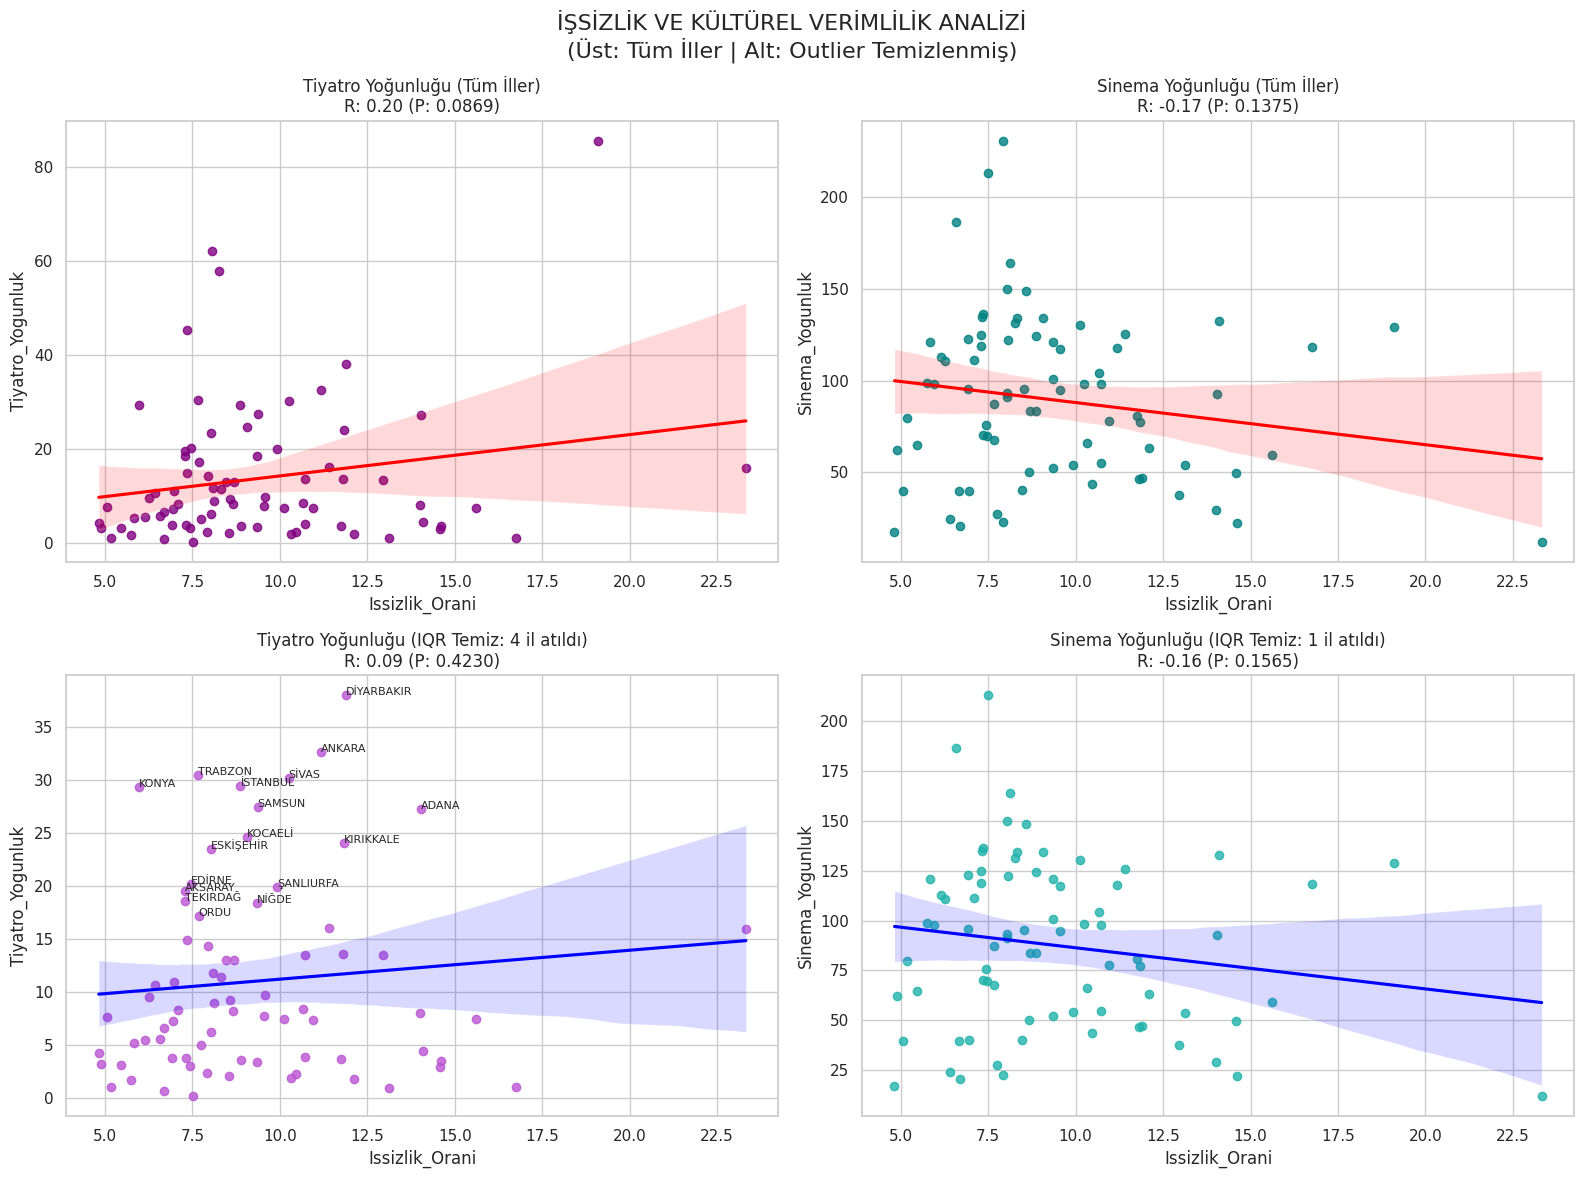


📊 DETAYLI SONUÇ TABLOSU
1️⃣ TİYATRO ANALİZİ:
   - TÜM İLLER: R=0.195 | P=0.08694 (ANLAMSIZ)
   - IQR TEMİZ: R=0.095  | P=0.42305  (ANLAMSIZ)
   * Atılan İller: ['BURSA', 'ÇORUM', 'ERZURUM', 'VAN']... (Toplam 4)
--------------------------------------------------------------------------------
2️⃣ SİNEMA ANALİZİ:
   - TÜM İLLER: R=-0.170 | P=0.13747 (ANLAMSIZ)
   - IQR TEMİZ: R=-0.163  | P=0.15646  (ANLAMSIZ)
   * Atılan İller: ['ELAZIĞ']... (Toplam 1)

🔥 KORELASYON ANALİZİ (TÜM DEĞİŞKENLER)


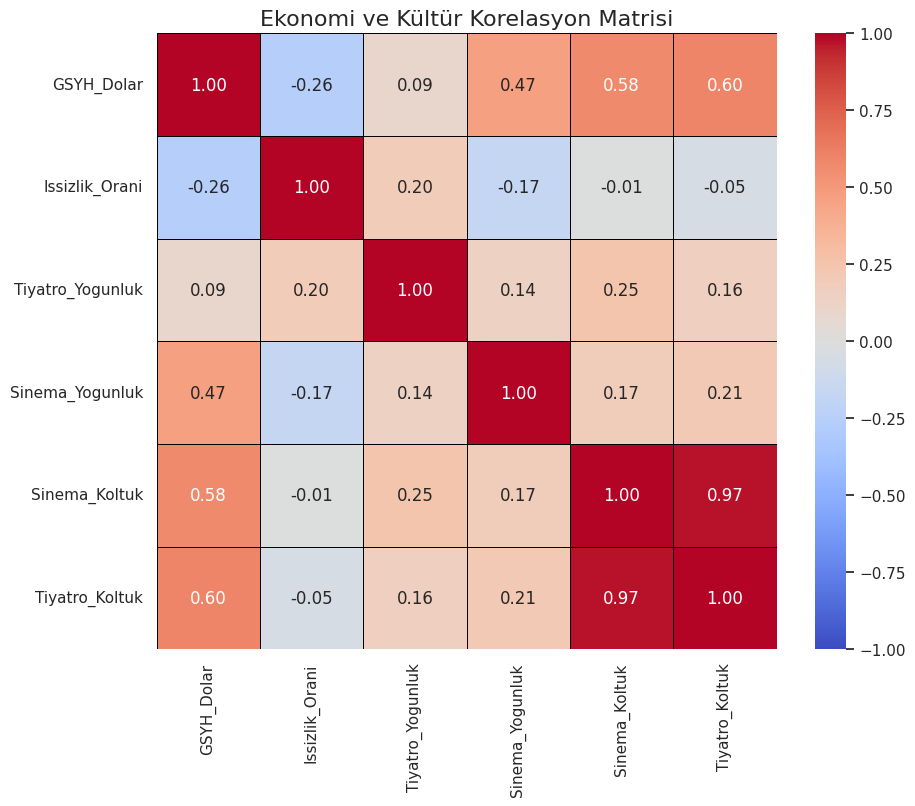

✅ Korelasyon Tablosu (Heatmap) Başarıyla Eklendi.

📈 EK ANALİZLER: ALTYAPI VE ZENGİNLİK İLİŞKİLERİ


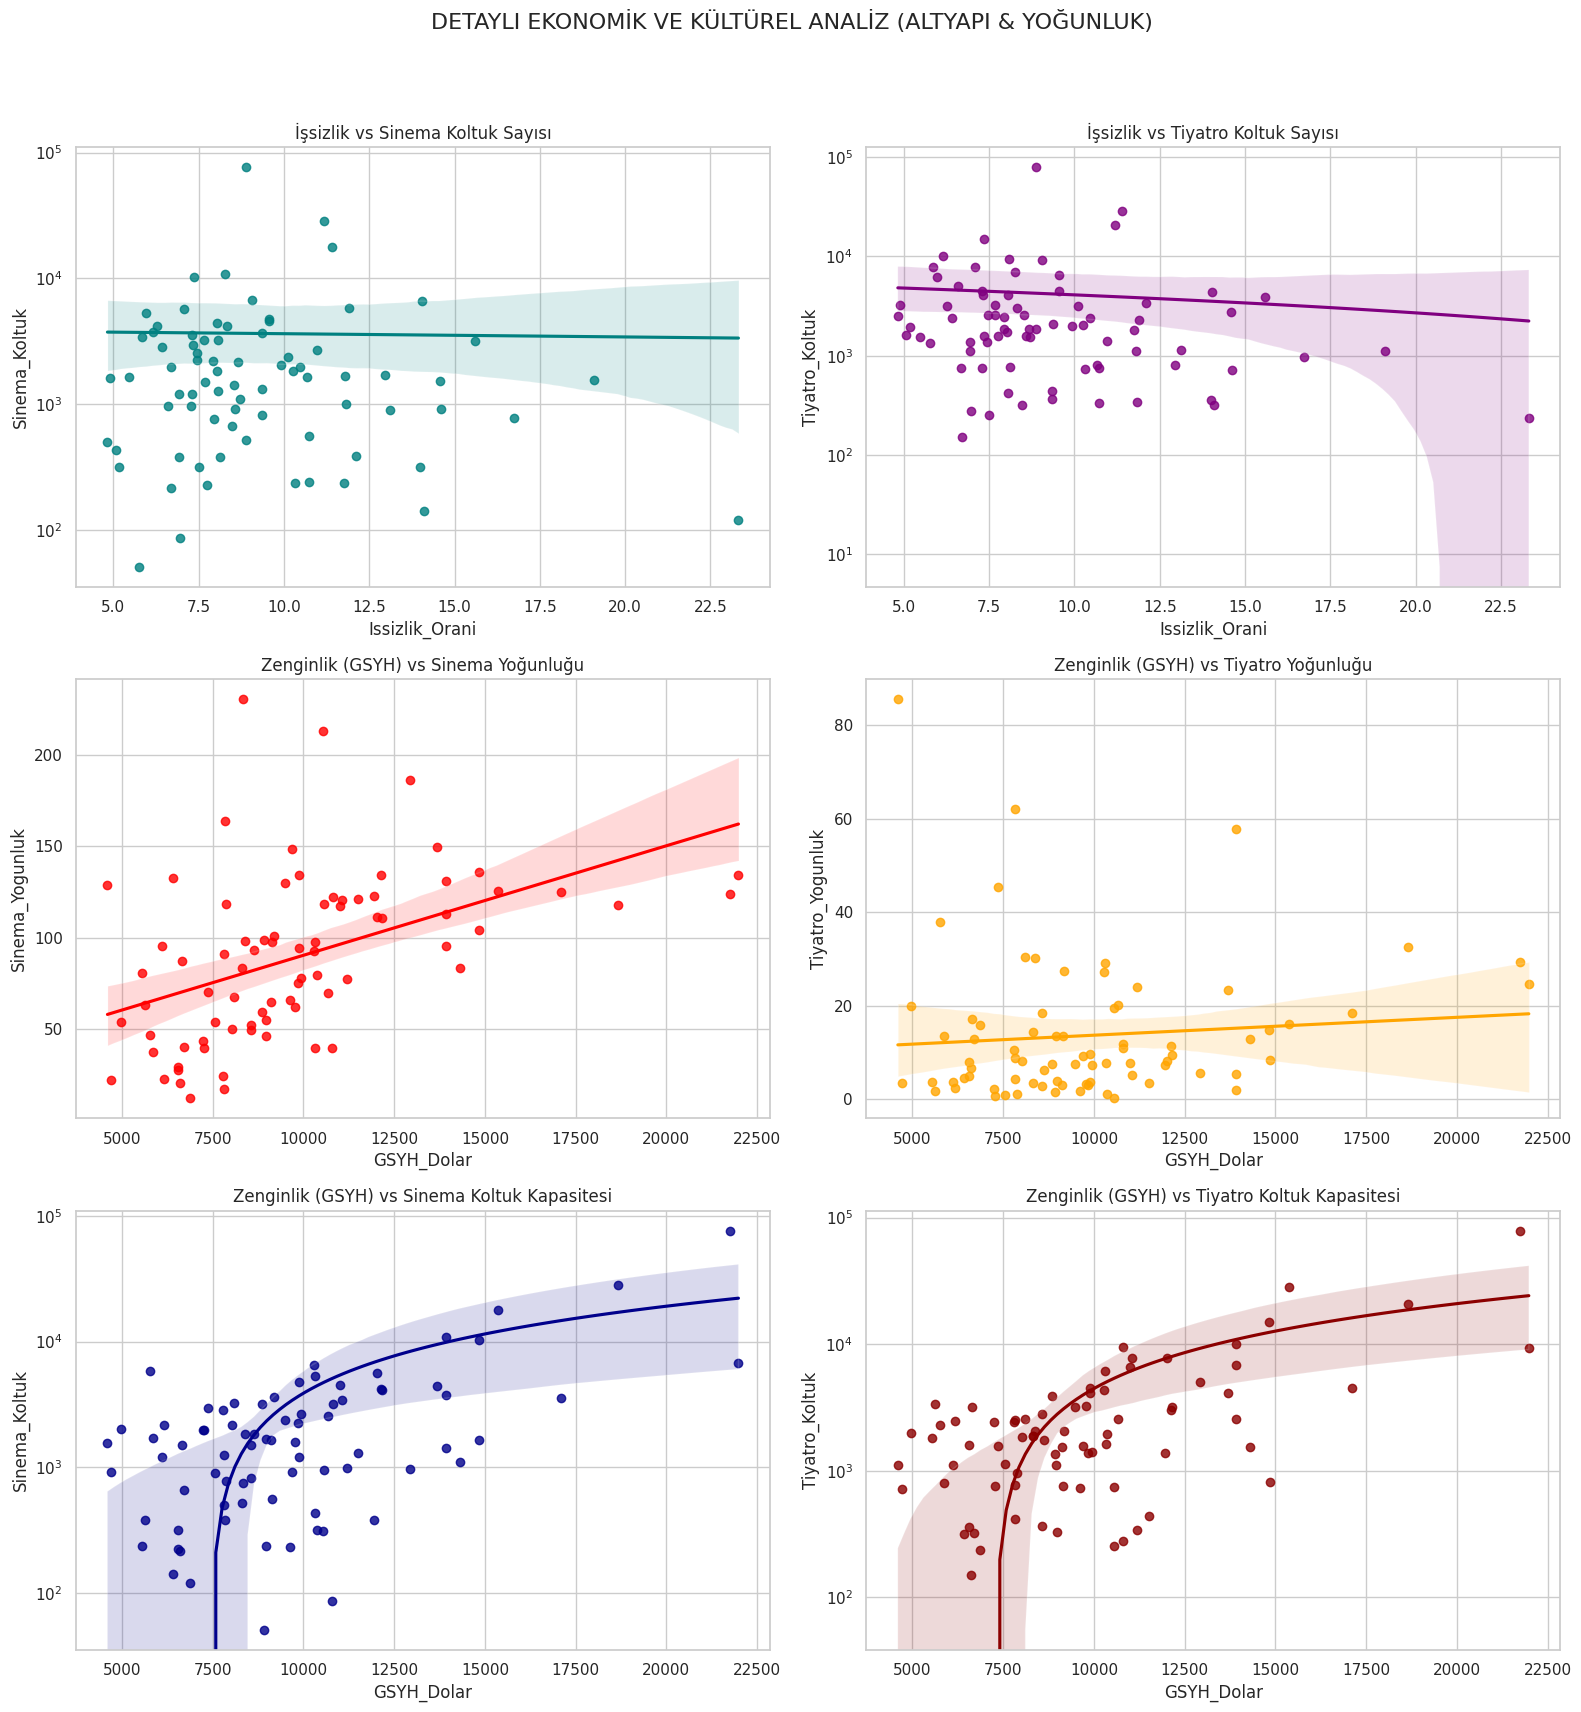

✅ Ekstra analiz grafikleri başarıyla çizildi.


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import os
from io import StringIO

# --- AYARLAR ---
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)

# --- 1. FONKSİYONLAR ---
def sehir_ismi_duzelt(isim):
    if isinstance(isim, str):
        if "TR" in isim:
            if "," in isim: isim = isim.split(',')[1]
            elif " " in isim: isim = isim.split(' ', 1)[1]
        isim = isim.replace('i', 'İ').upper()
        isim = isim.replace('ı', 'I')
        return isim.strip()
    return ""

def dosya_oku_koordinatli(anahtar_kelime, satir_baslangic):
    dosyalar = os.listdir('.')
    dosya_yolu = next((f for f in dosyalar if anahtar_kelime.lower() in f.lower()), None)

    if not dosya_yolu:
        print(f"⚠️ UYARI: '{anahtar_kelime}' kelimesini içeren dosya bulunamadı!")
        return None

    print(f"📖 Okunuyor: {dosya_yolu} (Başlangıç: {satir_baslangic}. satır)")
    skip = satir_baslangic - 1

    try:
        # Önce CSV olarak dene
        try:
            return pd.read_csv(dosya_yolu, skiprows=skip, header=None, sep=None, engine='python')
        except:
            # Olmazsa Excel olarak dene
            return pd.read_excel(dosya_yolu, skiprows=skip, header=None)
    except Exception as e:
        print(f"❌ '{dosya_yolu}' dosyası okunurken hata oluştu: {e}")
        return None

# --- IQR FİLTRELEME FONKSİYONU ---
def iqr_filtrele(df, kolon):
    """Aykırı değerleri temizler ve temiz veriyi döndürür."""
    Q1 = df[kolon].quantile(0.25)
    Q3 = df[kolon].quantile(0.75)
    IQR = Q3 - Q1
    alt = Q1 - 1.5 * IQR
    ust = Q3 + 1.5 * IQR
    df_clean = df[(df[kolon] >= alt) & (df[kolon] <= ust)]
    atilan_sayisi = len(df) - len(df_clean)
    atilanlar = df[~df.index.isin(df_clean.index)]['Il'].tolist()
    return df_clean, atilan_sayisi, atilanlar

print("🚀 KAPSAMLI VERİMLİLİK VE KORELASYON ANALİZİ BAŞLIYOR...")

try:
    # ---------------------------------------------------------
    # ADIM 1: VERİ OKUMA (GÜVENLİ YÖNTEM)
    # ---------------------------------------------------------

    # 1. İşsizlik
    temp_issizlik = dosya_oku_koordinatli("issizlik", 8)
    if temp_issizlik is None: raise ValueError("İşsizlik dosyası okunamadı! Dosyaları yüklediğinden emin ol.")
    df_issizlik = temp_issizlik.iloc[:, [1, 7]]
    df_issizlik.columns = ['Il', 'Issizlik_Orani']
    df_issizlik['Il'] = df_issizlik['Il'].apply(sehir_ismi_duzelt)

    # 2. Sinema
    temp_sinema = dosya_oku_koordinatli("sinema", 6)
    if temp_sinema is None: raise ValueError("Sinema dosyası okunamadı!")
    df_sinema = temp_sinema.iloc[:, [0, 2, 8]]
    df_sinema.columns = ['Il', 'Sinema_Koltuk', 'Sinema_Seyirci']
    df_sinema['Il'] = df_sinema['Il'].apply(sehir_ismi_duzelt)

    # 3. Tiyatro
    temp_tiyatro = dosya_oku_koordinatli("tiyatro", 7)
    if temp_tiyatro is None: raise ValueError("Tiyatro dosyası okunamadı!")
    df_tiyatro = temp_tiyatro.iloc[:, [0, 2, 12]]
    df_tiyatro.columns = ['Il', 'Tiyatro_Koltuk', 'Tiyatro_Seyirci']
    df_tiyatro['Il'] = df_tiyatro['Il'].apply(sehir_ismi_duzelt)

    # 4. GSYH (Gelir)
    temp_gsyh = dosya_oku_koordinatli("hasila", 6)
    if temp_gsyh is None: raise ValueError("GSYH (Hasıla) dosyası okunamadı!")
    df_gsyh = temp_gsyh.iloc[:, [1, 42]]
    df_gsyh.columns = ['Il', 'GSYH_Dolar']
    df_gsyh['Il'] = df_gsyh['Il'].apply(sehir_ismi_duzelt)

    # ---------------------------------------------------------
    # ADIM 2: BİRLEŞTİRME VE HESAPLAMA
    # ---------------------------------------------------------
    print("🔄 Veriler Birleştiriliyor...")
    df_master = df_sinema.merge(df_tiyatro, on='Il', how='inner')
    df_master = df_master.merge(df_issizlik, on='Il', how='inner')
    df_master = df_master.merge(df_gsyh, on='Il', how='inner')

    # Temizlik
    cols = ['Issizlik_Orani', 'Sinema_Koltuk', 'Sinema_Seyirci', 'Tiyatro_Koltuk', 'Tiyatro_Seyirci', 'GSYH_Dolar']
    for col in cols: df_master[col] = pd.to_numeric(df_master[col], errors='coerce').fillna(0)

    df_master = df_master[~df_master['Il'].str.contains("TURKIYE|TOPLAM", na=False)]
    df_master = df_master[df_master['Sinema_Koltuk'] > 0] # 0'a bölme hatası önlemi

    # Verimlilik (Yoğunluk) Hesapları
    df_master['Tiyatro_Yogunluk'] = df_master['Tiyatro_Seyirci'] / df_master['Tiyatro_Koltuk']
    df_master['Sinema_Yogunluk'] = df_master['Sinema_Seyirci'] / df_master['Sinema_Koltuk']

    # Sonsuz değerleri temizle
    df_master = df_master.replace([np.inf, -np.inf], 0)

    print(f"✅ Analiz Hazır! {len(df_master)} il işleniyor.")

    # ---------------------------------------------------------
    # ADIM 3: VERİLERİ HAZIRLAMA (IQR vs STANDART)
    # ---------------------------------------------------------

    # IQR Temizlenmiş Veriler
    df_clean_tiyatro, atilan_t_sayi, atilan_t_isim = iqr_filtrele(df_master, 'Tiyatro_Yogunluk')
    df_clean_sinema, atilan_s_sayi, atilan_s_isim = iqr_filtrele(df_master, 'Sinema_Yogunluk')

    # İstatistikler
    r_t_orig, p_t_orig = pearsonr(df_master['Issizlik_Orani'], df_master['Tiyatro_Yogunluk'])
    r_s_orig, p_s_orig = pearsonr(df_master['Issizlik_Orani'], df_master['Sinema_Yogunluk'])

    r_t_iqr, p_t_iqr = pearsonr(df_clean_tiyatro['Issizlik_Orani'], df_clean_tiyatro['Tiyatro_Yogunluk'])
    r_s_iqr, p_s_iqr = pearsonr(df_clean_sinema['Issizlik_Orani'], df_clean_sinema['Sinema_Yogunluk'])

    # ---------------------------------------------------------
    # ADIM 4: GÖRSELLEŞTİRME (SCATTER PLOTS)
    # ---------------------------------------------------------

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('İŞSİZLİK VE KÜLTÜREL VERİMLİLİK ANALİZİ\n(Üst: Tüm İller | Alt: Outlier Temizlenmiş)', fontsize=16)

    # 1. Tiyatro (Tüm İller)
    sns.regplot(data=df_master, x='Issizlik_Orani', y='Tiyatro_Yogunluk', ax=axes[0,0], color='purple', line_kws={'color':'red'})
    axes[0,0].set_title(f"Tiyatro Yoğunluğu (Tüm İller)\nR: {r_t_orig:.2f} (P: {p_t_orig:.4f})")

    # 2. Sinema (Tüm İller)
    sns.regplot(data=df_master, x='Issizlik_Orani', y='Sinema_Yogunluk', ax=axes[0,1], color='teal', line_kws={'color':'red'})
    axes[0,1].set_title(f"Sinema Yoğunluğu (Tüm İller)\nR: {r_s_orig:.2f} (P: {p_s_orig:.4f})")

    # 3. Tiyatro (IQR Temizlenmiş)
    sns.regplot(data=df_clean_tiyatro, x='Issizlik_Orani', y='Tiyatro_Yogunluk', ax=axes[1,0], color='mediumorchid', line_kws={'color':'blue'})
    axes[1,0].set_title(f"Tiyatro Yoğunluğu (IQR Temiz: {atilan_t_sayi} il atıldı)\nR: {r_t_iqr:.2f} (P: {p_t_iqr:.4f})")

    # 4. Sinema (IQR Temizlenmiş)
    sns.regplot(data=df_clean_sinema, x='Issizlik_Orani', y='Sinema_Yogunluk', ax=axes[1,1], color='lightseagreen', line_kws={'color':'blue'})
    axes[1,1].set_title(f"Sinema Yoğunluğu (IQR Temiz: {atilan_s_sayi} il atıldı)\nR: {r_s_iqr:.2f} (P: {p_s_iqr:.4f})")

    # Şehir isimlerini yazdır
    for i in range(len(df_clean_tiyatro)):
        row = df_clean_tiyatro.iloc[i]
        if row['Tiyatro_Yogunluk'] > df_clean_tiyatro['Tiyatro_Yogunluk'].mean() * 1.5:
            axes[1,0].text(row['Issizlik_Orani'], row['Tiyatro_Yogunluk'], row['Il'], fontsize=8)

    plt.tight_layout()
    plt.show()

    # ---------------------------------------------------------
    # ADIM 5: SONUÇ RAPORU (TEXT)
    # ---------------------------------------------------------
    print("\n" + "="*80)
    print("📊 DETAYLI SONUÇ TABLOSU")
    print("="*80)

    print(f"1️⃣ TİYATRO ANALİZİ:")
    print(f"   - TÜM İLLER: R={r_t_orig:.3f} | P={p_t_orig:.5f} ({'ANLAMLI' if p_t_orig<0.05 else 'ANLAMSIZ'})")
    print(f"   - IQR TEMİZ: R={r_t_iqr:.3f}  | P={p_t_iqr:.5f}  ({'ANLAMLI' if p_t_iqr<0.05 else 'ANLAMSIZ'})")
    print(f"   * Atılan İller: {atilan_t_isim[:5]}... (Toplam {atilan_t_sayi})")

    print("-" * 80)

    print(f"2️⃣ SİNEMA ANALİZİ:")
    print(f"   - TÜM İLLER: R={r_s_orig:.3f} | P={p_s_orig:.5f} ({'ANLAMLI' if p_s_orig<0.05 else 'ANLAMSIZ'})")
    print(f"   - IQR TEMİZ: R={r_s_iqr:.3f}  | P={p_s_iqr:.5f}  ({'ANLAMLI' if p_s_iqr<0.05 else 'ANLAMSIZ'})")
    print(f"   * Atılan İller: {atilan_s_isim[:5]}... (Toplam {atilan_s_sayi})")
    print("="*80)

    # ---------------------------------------------------------
    # ADIM 6: EKSTRA - DETAYLI KORELASYON ANALİZİ (HEATMAP)
    # ---------------------------------------------------------

    print("\n" + "="*80)
    print("🔥 KORELASYON ANALİZİ (TÜM DEĞİŞKENLER)")
    print("="*80)

    # Analiz edilecek sütunları seç (Verimlilik Metrikleri + Ekonomi)
    analiz_sutunlari = [
        'GSYH_Dolar',
        'Issizlik_Orani',
        'Tiyatro_Yogunluk',
        'Sinema_Yogunluk',
        'Sinema_Koltuk',
        'Tiyatro_Koltuk'
    ]

    # Korelasyon matrisini hesapla
    corr_matrix = df_master[analiz_sutunlari].corr()

    # Isı Haritasını Çiz
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix,
                annot=True,
                fmt=".2f",
                cmap='coolwarm',
                vmin=-1, vmax=1,
                linewidths=0.5,
                linecolor='black')

    plt.title('Ekonomi ve Kültür Korelasyon Matrisi', fontsize=16)
    plt.show()

    print("✅ Korelasyon Tablosu (Heatmap) Başarıyla Eklendi.")
    # ---------------------------------------------------------
    # ADIM 7: EKSTRA - GENİŞLETİLMİŞ ANALİZ GRAFİKLERİ (YENİ İSTEK)
    # ---------------------------------------------------------

    print("\n" + "="*80)
    print("📈 EK ANALİZLER: ALTYAPI VE ZENGİNLİK İLİŞKİLERİ")
    print("="*80)

    # 3x2'lik Büyük Bir Grafik Paneli Oluştur
    fig_extra, axes_ex = plt.subplots(3, 2, figsize=(16, 18))
    fig_extra.suptitle('DETAYLI EKONOMİK VE KÜLTÜREL ANALİZ (ALTYAPI & YOĞUNLUK)', fontsize=16)

    # 1. İşsizlik vs Koltuk Sayısı (Altyapı)
    sns.regplot(data=df_master, x='Issizlik_Orani', y='Sinema_Koltuk', ax=axes_ex[0,0], color='teal')
    axes_ex[0,0].set_title('İşsizlik vs Sinema Koltuk Sayısı')
    axes_ex[0,0].set_yscale('log') # Logaritmik ölçek (İstanbul verisi grafiği bozmasın diye)

    sns.regplot(data=df_master, x='Issizlik_Orani', y='Tiyatro_Koltuk', ax=axes_ex[0,1], color='purple')
    axes_ex[0,1].set_title('İşsizlik vs Tiyatro Koltuk Sayısı')
    axes_ex[0,1].set_yscale('log')

    # 2. GSYH (Zenginlik) vs Yoğunluk (Verimlilik)
    sns.regplot(data=df_master, x='GSYH_Dolar', y='Sinema_Yogunluk', ax=axes_ex[1,0], color='red')
    axes_ex[1,0].set_title('Zenginlik (GSYH) vs Sinema Yoğunluğu')

    sns.regplot(data=df_master, x='GSYH_Dolar', y='Tiyatro_Yogunluk', ax=axes_ex[1,1], color='orange')
    axes_ex[1,1].set_title('Zenginlik (GSYH) vs Tiyatro Yoğunluğu')

    # 3. GSYH (Zenginlik) vs Koltuk Sayısı (Altyapı)
    sns.regplot(data=df_master, x='GSYH_Dolar', y='Sinema_Koltuk', ax=axes_ex[2,0], color='darkblue')
    axes_ex[2,0].set_title('Zenginlik (GSYH) vs Sinema Koltuk Kapasitesi')
    axes_ex[2,0].set_yscale('log')

    sns.regplot(data=df_master, x='GSYH_Dolar', y='Tiyatro_Koltuk', ax=axes_ex[2,1], color='darkred')
    axes_ex[2,1].set_title('Zenginlik (GSYH) vs Tiyatro Koltuk Kapasitesi')
    axes_ex[2,1].set_yscale('log')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Başlık için yer aç
    plt.show()

    print("✅ Ekstra analiz grafikleri başarıyla çizildi.")


except Exception as e:
    print(f"❌ HATA: {e}")